# Prophet

Importing necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import mlflow
import HydroErr as he

from prophet import Prophet, serialize
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.model_selection import train_test_split

import logging, sys
logging.disable(sys.maxsize) # Disable INFO

import warnings
warnings.filterwarnings("ignore") # Prevents warnings from being displayed

### Load dataset

In [2]:
#Change to the series to process

df = pd.read_csv('https://raw.githubusercontent.com/aledor07/Hydrologic-time-series-analysis/main/2046-Diaria.csv')

df = df.dropna()

df["ds"] =  pd.to_datetime(df["ds"], format="%d/%m/%Y")
df.set_index(df['ds'], inplace=True)

#Serie diaria
df_d = df.resample('D', on='ds').sum()

df_d.index.names = ['ds']
df_d.reset_index(inplace=True)

#Serie mensual
df_m = df.copy()
df_m["y"] = (df_m["y"] * 3600*24)/1000000 # Monthly
df_m = df_m.resample('M', on='ds').sum()

df_m.index.names = ['ds']
df_m.reset_index(inplace=True)

#Serie anual
df_a = df.copy()
df_a["y"] = (df_a["y"] * 3600*24)/1000000 # Yearly
df_a['water_year'] = df_a.ds.dt.year.where(df_a.ds.dt.month < 10, df_a.ds.dt.year + 1) # We define the hydrological year
df_a = df_a.groupby('water_year')[['y']].sum() # Grouping by hydrological year

df_a.index.names = ['ds']
df_a.reset_index(inplace=True)
df_a["ds"] =  pd.to_datetime(df_a["ds"], format="%Y")


In [3]:
# Training and test split

test_size = 0.18

train, test = train_test_split(df_m, shuffle = False, test_size = test_size)

print(f"Number of obs. in train data: {len(train)}")
print(f"Number of obs. in test data: {len(test)}")

Number of obs. in train data: 757
Number of obs. in test data: 167


### Setting up MLFlow environment

In [15]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("PROPHET")

<Experiment: artifact_location='./mlruns/1', creation_time=1691934215196, experiment_id='1', last_update_time=1691934215196, lifecycle_stage='active', name='PROPHET', tags={}>

### Execution of the model - Adjustment to the training period

In [7]:
%%time
# We define the function to extract the hyperparameters from the Prophet model to be executed to save them in MLFlow

def extract_params(prophet_model):
    return {attr: getattr(prophet_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}


with mlflow.start_run():
    

    prophet_model = Prophet(
        
        # Hyperparameters - Change to best fit
                            #yearly_seasonality='false',
                            #weekly_seasonality='false',
                            seasonality_prior_scale=10,
                            daily_seasonality=False,
                            changepoint_prior_scale=0.015,
                            changepoint_range=0.75,
                            growth='linear',
                            interval_width=0.95
                            )
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=7, prior_scale=10, mode ='multiplicative')
    prophet_model.fit(train)
    
    mlflow.prophet.log_model(prophet_model, registered_model_name = 'Mijares-Mensual', artifact_path = 'prophet-model') # Cambiar el nombre del modelo

    mlflow.log_params(extract_params(prophet_model))
    
    # We create the array with the period for which we want to make the prediction
    prediction_period = prophet_model.make_future_dataframe(periods = len(test), freq ='MS', include_history=True)

    # he prediction is made
    forecast = prophet_model.predict(prediction_period)
    
    # We value the fit with the metrics
    real = df_m['y']
    real = real.set_axis(df_m['ds'])
    
    forecast.yhat[forecast.yhat.lt(0)] = 0 # Negative predictive values ​​are removed

    predictions = forecast.iloc[-len(test):]['yhat']
    predictions = predictions.set_axis(forecast.iloc[-len(test):]['ds'])
    fits = forecast.iloc[:len(train)]['yhat']
    fits = fits.set_axis(forecast.iloc[:len(train)]['ds'])
    actuals = test['y']
    actuals = actuals.set_axis(forecast.iloc[-len(test):]['ds'])
    
    RMSE = he.rmse(predictions, actuals)
    MAE = he.mae(predictions, actuals)
    NSE = he.nse(predictions, actuals)

    
    mlflow.log_metric('RMSE', RMSE)
    mlflow.log_metric('MAE', MAE)
    mlflow.log_metric('NSE', NSE)
    mlflow.log_metric('Test_size', test_size)



Wall time: 693 ms


### Prediction with the fitted model

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
919,2019-05-01,11.956345,-20.454988,42.140545
920,2019-06-01,9.964969,-23.772577,38.350229
921,2019-07-01,0.361462,-32.152833,35.003482
922,2019-08-01,0.000000,-36.396672,27.955095
923,2019-09-01,0.000000,-37.322004,24.043433


### Coefficients

In [9]:
print('MAE: '+str(MAE))
print('RMSE: '+str(RMSE))
print('NSE: '+str(NSE))

MAE: 5.193268401815152
RMSE: 7.850228174335253
NSE: 0.014180051419907413


### Graph of results

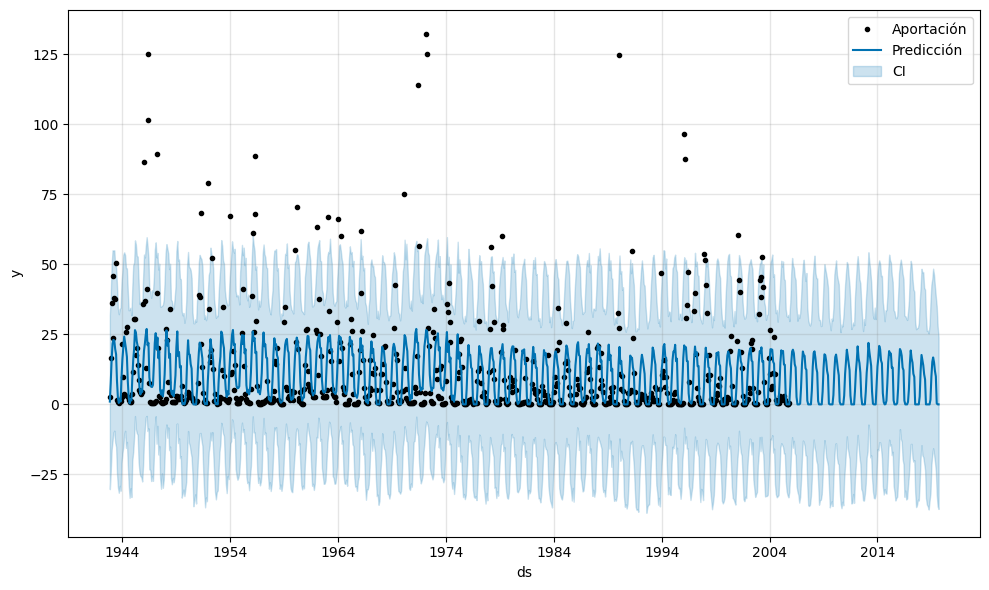

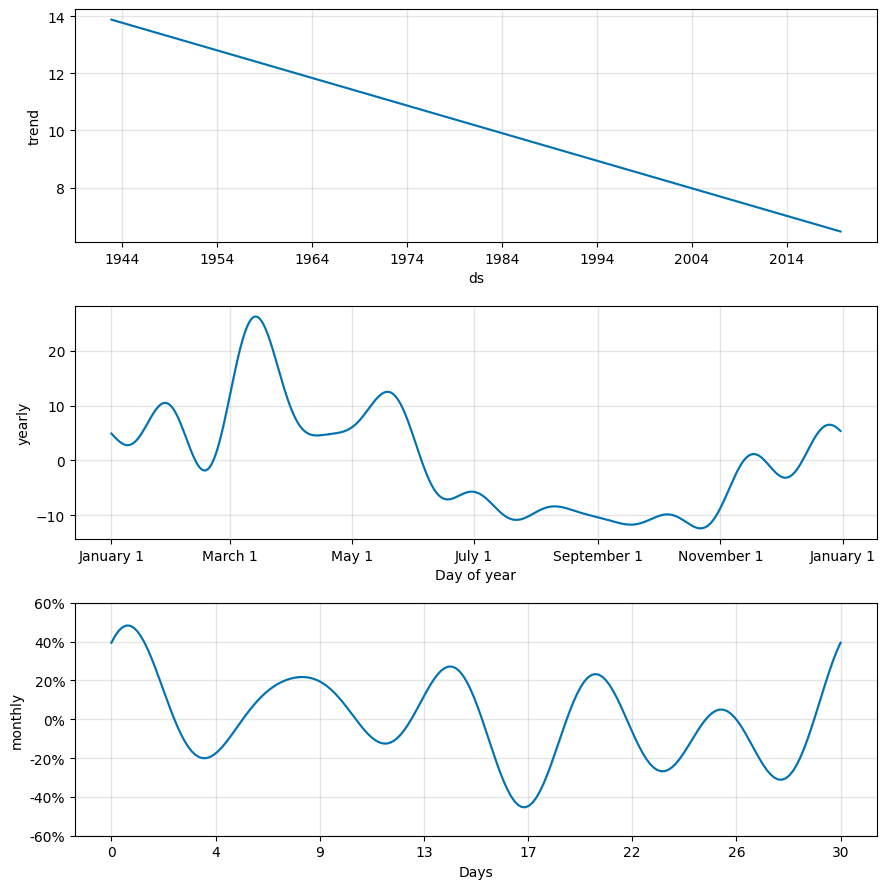

In [10]:
fig1 = prophet_model.plot(forecast)
plt.legend(['Aportación', 'Predicción', 'CI'])
plt.show()

fig2 = prophet_model.plot_components(forecast)


### Trend changepoints

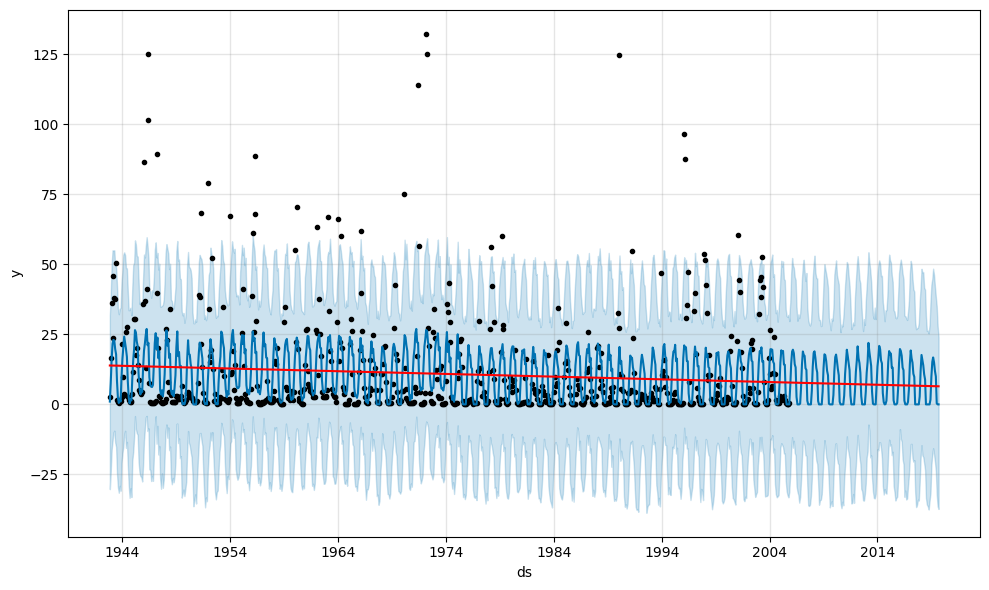

In [11]:
fig = prophet_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast)

### Forecasts

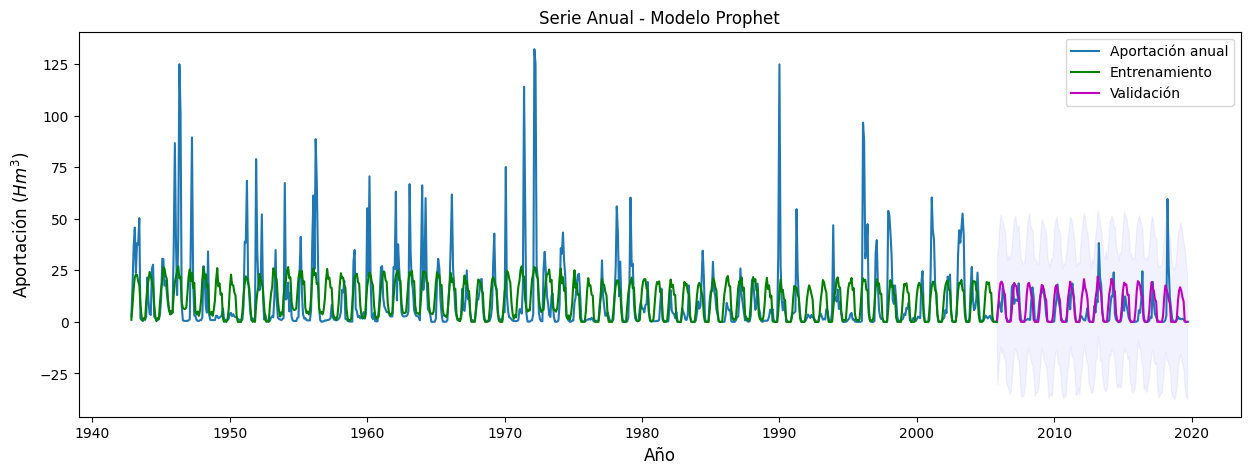

In [12]:
# Forecast plot

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(real, linestyle = 'solid')
ax.plot(fits, color = 'green',linestyle = 'solid')
ax.plot(predictions, color = 'm',linestyle = 'solid')
ax.fill_between(predictions.index,
                forecast.iloc[-len(test):]['yhat_lower'],
                forecast.iloc[-len(test):]['yhat_upper'],color='blue',alpha=.05)

plt.title('Serie Anual - Modelo Prophet')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','Entrenamiento','Validación'])


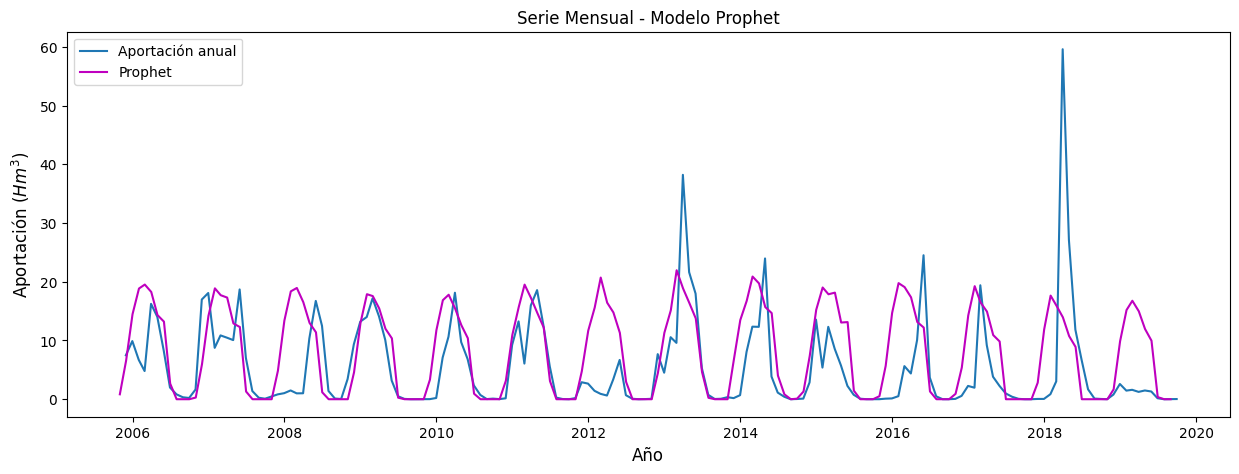

In [13]:
# Forecast plot

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(real.iloc[-len(test):], linestyle = 'solid')
ax.plot(predictions, color = 'm',linestyle = 'solid')
#ax.fill_between(predictions.index,
                #forecast.iloc[-len(test):]['yhat_lower'],
                #forecast.iloc[-len(test):]['yhat_upper'],color='blue',alpha=.05)

plt.title('Serie Mensual - Modelo Prophet')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Aportación ($Hm^3$)', fontsize=12)
plt.legend(['Aportación anual','Prophet'])


In [ ]:
# Saving model results

model_results = pd.concat([predictions, real.iloc[-len(test):]], axis=1)
model_results.rename(columns = {0:'Forecast', 1:'Test'}, inplace = True)
model_results

model_results.to_excel(r'', index=True)

### Grid search - Cross Validation

In [ ]:
%%time
#Grid search

initial = str(len(train)*365) # Equal to the number of year in training set


param_grid = {  
    
    'yearly_seasonality': ['auto'],
    'weekly_seasonality': ['auto'],                    
    'daily_seasonality': [False],
    'changepoint_prior_scale': [0.001,0.015,0.05,0.5,0.1,0.005,5,10],
    'changepoint_range': [0.70, 0.80, 0.85, 0.90],
    'growth': ['linear'],
    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
coefficients = []  # Store the coefficients for each params here
coefficients_1 = []

# Use cross validation to evaluate all parameters
for params in all_params:
    
    prophet_model = Prophet(**params).fit(df_m)
    #prophet_model = Prophet(**params).add_seasonality(name='monthly', period=30.5, fourier_order=6, prior_scale=10, mode ='multiplicative').fit(df_m)  # Fit model with given params (Cambiar dataframe según escala temporal)
    df_cv = cross_validation(prophet_model, initial=initial, period='1825 days', horizon = '1825 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['nse']=1-(df_p['rmse']/np.std(df_cv['y']))**2
    
    coefficients.append(df_p['nse'].values[0]) 
    coefficients_1.append(df_p['rmse'].values[0]) # Change for the objetive metric

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['nse'] = coefficients 
tuning_results['rmse'] = coefficients_1 
print(tuning_results)

In [ ]:
# CV Results
best_params = all_params[np.argmax(coefficients)]
print(best_params)

## Forecast

In [ ]:
#Cambiar hiperparámetros y periodo de predicción

prophet_model = Prophet(
        #Hiperparámetros - Cambiar por los de mejor ajuste
                        yearly_seasonality='auto',
                        weekly_seasonality='auto',
                        #seasonality_prior_scale=10,
                        daily_seasonality=False,
                        changepoint_prior_scale=0.01,
                        changepoint_range=0.70,
                        growth='linear',
                        interval_width=0.95
    
                        )
#prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=7, prior_scale=10, mode ='multiplicative')
prophet_model.fit(df_m)

prediction_period = prophet_model.make_future_dataframe(periods = 24, freq ='MS', include_history=False)
forecast = prophet_model.predict(prediction_period)
forecast.yhat[forecast.yhat.lt(0)] = 0 # Se eliminan los valores negativos predictivos
forecast